In [1]:
import tensorflow as tf
print(tf.__version__)


tf.config.list_physical_devices('GPU')
tf.test.is_gpu_available()

2.6.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

# Loading Data and necessary libraries

In [2]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

import random

from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.utils import np_utils
from keras.models import Sequential, load_model
from keras import layers
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [3]:
#Reading using pandas
train_df = pd.read_csv('./Datasets/EMNIST/emnist-balanced-train.csv', header=None)
test_df = pd.read_csv('./Datasets/EMNIST/emnist-balanced-test.csv', header=None)
# Add test dataset into train dataset
df = pd.concat([train_df, test_df], ignore_index=True)
df.head()
# Clear memory
del train_df
del test_df

In [4]:
#Reading the file
label_map = pd.read_csv("./Datasets/EMNIST/emnist-balanced-mapping.txt",
                        delimiter = ' ',
                        index_col=0,
                        header=None)
label_map = label_map.iloc[:, 0]

#Initialising an empty dictionary
label_dictionary = {}

#Running a loop for ASCII equivalent to character conversion
for index, label in enumerate(label_map):
    label_dictionary[index] = chr(label)

label_dictionary

{0: '0',
 1: '1',
 2: '2',
 3: '3',
 4: '4',
 5: '5',
 6: '6',
 7: '7',
 8: '8',
 9: '9',
 10: 'A',
 11: 'B',
 12: 'C',
 13: 'D',
 14: 'E',
 15: 'F',
 16: 'G',
 17: 'H',
 18: 'I',
 19: 'J',
 20: 'K',
 21: 'L',
 22: 'M',
 23: 'N',
 24: 'O',
 25: 'P',
 26: 'Q',
 27: 'R',
 28: 'S',
 29: 'T',
 30: 'U',
 31: 'V',
 32: 'W',
 33: 'X',
 34: 'Y',
 35: 'Z',
 36: 'a',
 37: 'b',
 38: 'd',
 39: 'e',
 40: 'f',
 41: 'g',
 42: 'h',
 43: 'n',
 44: 'q',
 45: 'r',
 46: 't'}

In [5]:
df.shape

(131600, 785)

In [6]:
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
count,131600.000000,131600.0,131600.0,131600.0,131600.0,131600.000000,131600.000000,131600.000000,131600.000000,131600.000000,...,131600.000000,131600.0,131600.0,131600.000000,131600.000000,131600.0,131600.0,131600.0,131600.0,131600.0
mean,23.000000,0.0,0.0,0.0,0.0,0.002036,0.012728,0.019354,0.016284,0.017447,...,0.000266,0.0,0.0,0.001854,0.000243,0.0,0.0,0.0,0.0,0.0
std,13.564712,0.0,0.0,0.0,0.0,0.295477,1.312534,1.586618,1.521459,1.692130,...,0.096481,0.0,0.0,0.672608,0.088211,0.0,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
25%,11.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
50%,23.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
75%,35.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
max,46.000000,0.0,0.0,0.0,0.0,63.000000,213.000000,217.000000,217.000000,217.000000,...,35.000000,0.0,0.0,244.000000,32.000000,0.0,0.0,0.0,0.0,0.0


# Preprocessing data

In [7]:
# Is there any missing values
df.dropna(inplace=True)
num_missing_values = df.isnull().sum().sum()

# Remove duplicates if any
df.drop_duplicates(inplace=True)
num_duplicates = df.duplicated().sum()

# Make sure the grayscale values to be between 0 and 255
df = np.clip(df, 0, 255)
num_values_outside_range = ((df < 0) | (df > 255)).sum().sum()

# Check if we have any null values or duplicated rows or values outside (0, 255) range.
print(f"Any missing value? {num_missing_values}")
print(f"Any duplicates? {num_duplicates}")
print(f"Any values outside the range of 0 and 255? {num_values_outside_range}")

Any missing value? 0
Any duplicates? 0
Any values outside the range of 0 and 255? 0


In [8]:
# We split our dataframe into feature matrix (X) and target vector (y)
X = df.loc[:, 1:]
y = df.loc[:, 0]

X.shape, y.shape

del df

In [9]:
#Data Scaling to bring the input values between 0 to 1
X = X.astype('float32') / 255

# Convert target variable to integer labels
y = y.astype(int)

In [10]:
# Sample entry number 263
sample_image = X.iloc[42]
sample_label = y.iloc[42]
sample_image.shape, sample_label

((784,), 23)

Label entry No. 42: N


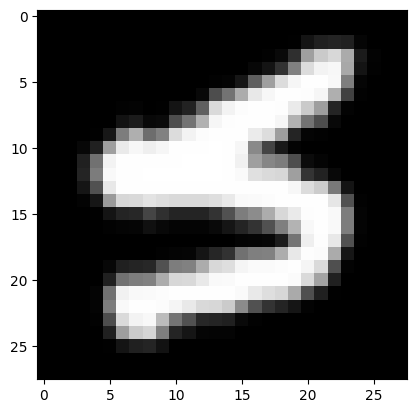

In [11]:
print("Label entry No. 42:", label_dictionary[sample_label])
plt.imshow(sample_image.values.reshape(28, 28), cmap=plt.cm.gray)
plt.show()

In [12]:
def flip_and_rotate(image):
    W = 28
    H = 28
    image = image.reshape(28, 28)
    image = np.fliplr(image)
    image = np.rot90(image)
    return image

Label entry 42: N


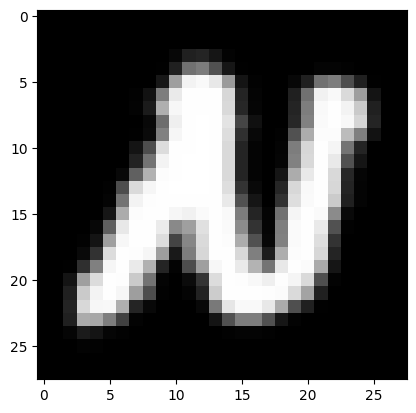

In [13]:
print("Label entry 42:", label_dictionary[sample_label])
plt.imshow(flip_and_rotate(sample_image.values), cmap=plt.cm.gray)
plt.show()

In [14]:
# Next we want to apply reshape_and_rotate to all images in X_train
X = np.asarray(X)
X = np.apply_along_axis(flip_and_rotate, 1, X)
X.shape

(131598, 28, 28)

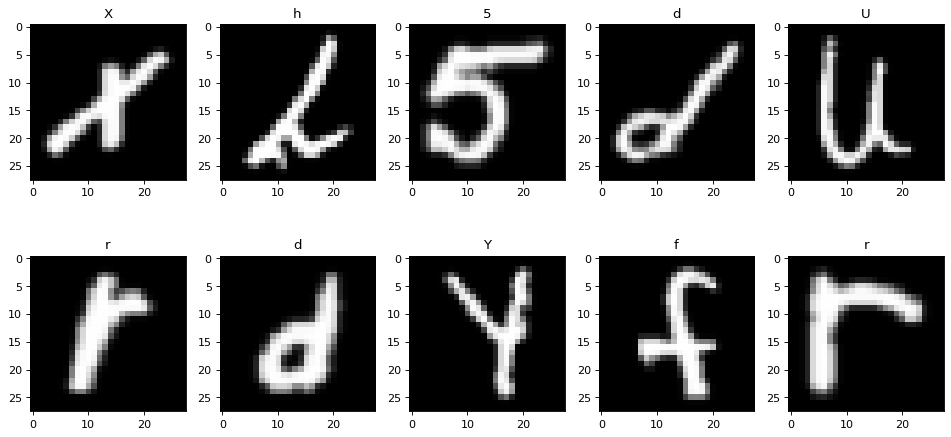

In [15]:
plt.figure(figsize=(12, 6), dpi=80)  # Adjust the figure size to accommodate two rows
for i in range(100, 110):  # Update the range to select 10 samples
    plt.subplot(2, 5, i - 99)  # Use 2 rows and 5 columns for displaying the samples
    plt.imshow(X[i], cmap=plt.cm.gray)
    plt.title(label_dictionary[y[i]])
plt.tight_layout()  # Adjust the spacing between subplots
plt.show()

In [16]:
#Finding the number of output columns
number_of_classes = y.nunique()
number_of_classes

47

In [17]:
#One hot encoding of numpy array
y = np_utils.to_categorical(y, number_of_classes)
y.shape

(131598, 47)

In [18]:
# Reshaping the train data
# As tensorflow requires 4D Array, (batch X width X height X channel) and our x_train is 3D array (no. of images X width X height), we will be adding one more dimension to the x_train
X = X.reshape(-1, 28, 28, 1)
X.shape

(131598, 28, 28, 1)

# Split Data

In [19]:
# Split 20% validation 
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                  y, 
                                                  test_size= 0.2,
                                                  stratify = y,
                                                  random_state=88)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
del X
del y

(105278, 28, 28, 1)
(26320, 28, 28, 1)
(105278, 47)
(26320, 47)


# Build CNN model

cnn_model = Sequential()

cnn_model.add(layers.Conv2D(filters=32, kernel_size=(5,5), padding='same', activation='relu', input_shape=(28, 28, 1)))
cnn_model.add(layers.MaxPool2D(strides=2))

cnn_model.add(layers.Conv2D(filters=48, kernel_size=(5,5), padding='valid', activation='relu'))
cnn_model.add(layers.MaxPool2D(strides=2))

cnn_model.add(layers.Flatten())

cnn_model.add(layers.Dense(256, activation='relu'))
cnn_model.add(layers.Dense(84, activation='relu'))

cnn_model.add(layers.Dropout(0.2))

cnn_model.add(layers.Dense(number_of_classes, activation='softmax'))

cnn_model.summary()

In [20]:
cnn_model = Sequential()

cnn_model.add(layers.Conv2D(filters=32, kernel_size=(5,5), padding='same', activation='relu', input_shape=(28, 28, 1)))
cnn_model.add(layers.MaxPool2D(strides=2))

cnn_model.add(layers.Conv2D(filters=48, kernel_size=(5,5), padding='valid', activation='relu'))
cnn_model.add(layers.MaxPool2D(strides=2))

cnn_model.add(layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
cnn_model.add(layers.MaxPool2D(strides=2))

cnn_model.add(layers.Flatten())

cnn_model.add(layers.Dense(256, activation='relu'))
cnn_model.add(layers.Dense(84, activation='relu'))

cnn_model.add(layers.Dropout(0.2))

cnn_model.add(layers.Dense(number_of_classes, activation='softmax'))

cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 48)        38448     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 48)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 5, 64)          27712     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 2, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 256)               0

cnn_model = Sequential()
cnn_model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', strides=(1,1), activation='relu', input_shape=(28, 28, 1)))
cnn_model.add(layers.Dropout(.2))
cnn_model.add(layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
cnn_model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', strides=(1,1), activation='relu'))
cnn_model.add(layers.Dropout(.2))
cnn_model.add(layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(units=128, activation='relu'))
cnn_model.add(layers.Dropout(.5))
cnn_model.add(layers.Dense(units=47, activation='softmax'))

cnn_model.summary()

In [21]:
# Compile the CNN model with categorical cross-entropy loss, the specified optimizer, and accuracy metric
cnn_model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

# Create an EarlyStopping callback to monitor validation loss and stop training if it doesn't improve for 5 epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min')

# Create a ModelCheckpoint callback to save the best model during training based on validation loss
mcp_save = ModelCheckpoint('./saved/cnn.h5', save_best_only=True, monitor='val_loss', verbose=1, mode='auto')

# Create a ReduceLROnPlateau callback to reduce the learning rate if validation loss plateaus for 3 epochs
RLP = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.2, min_lr=0.0001)

In [22]:
# Model Fitting
history = cnn_model.fit(X_train,  # Training data features
                        y_train,  # Training data labels
                        epochs=100,  # Number of epochs for training the model
                        batch_size=32,  # Number of samples per gradient update
                        verbose=2,  # Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch
                        validation_data=(X_test, y_test),  # Validation data for evaluating the model
                        callbacks=[mcp_save, early_stopping, RLP])  # Callbacks for additional functionality during training

Epoch 1/100
3290/3290 - 22s - loss: 0.7720 - accuracy: 0.7547 - val_loss: 0.4414 - val_accuracy: 0.8440

Epoch 00001: val_loss improved from inf to 0.44144, saving model to ./saved\cnn.h5
Epoch 2/100
3290/3290 - 12s - loss: 0.4216 - accuracy: 0.8529 - val_loss: 0.3806 - val_accuracy: 0.8659

Epoch 00002: val_loss improved from 0.44144 to 0.38064, saving model to ./saved\cnn.h5
Epoch 3/100
3290/3290 - 12s - loss: 0.3682 - accuracy: 0.8689 - val_loss: 0.3762 - val_accuracy: 0.8665

Epoch 00003: val_loss improved from 0.38064 to 0.37622, saving model to ./saved\cnn.h5
Epoch 4/100
3290/3290 - 12s - loss: 0.3380 - accuracy: 0.8777 - val_loss: 0.3499 - val_accuracy: 0.8750

Epoch 00004: val_loss improved from 0.37622 to 0.34992, saving model to ./saved\cnn.h5
Epoch 5/100
3290/3290 - 12s - loss: 0.3144 - accuracy: 0.8845 - val_loss: 0.3415 - val_accuracy: 0.8787

Epoch 00005: val_loss improved from 0.34992 to 0.34145, saving model to ./saved\cnn.h5
Epoch 6/100
3290/3290 - 11s - loss: 0.2978 -

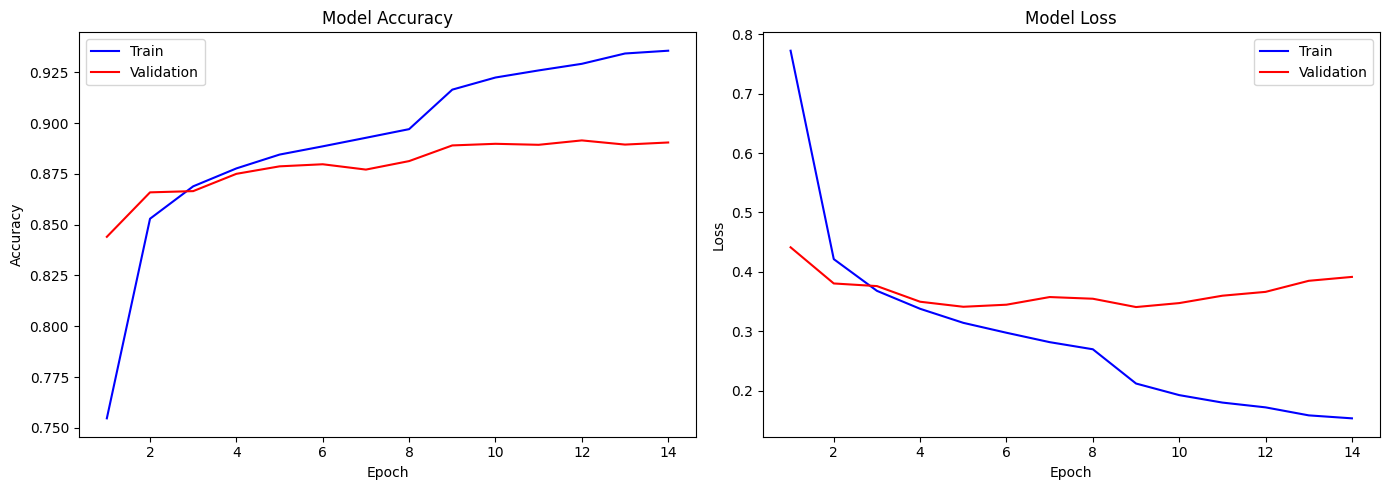

In [24]:
import matplotlib.pyplot as plt

def plot_combined_graph(epochs, acc, val_acc, loss, val_loss):
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))  # 1 row, 2 columns
    
    # Plot training & validation accuracy
    axs[0].plot(epochs, acc, 'b')
    axs[0].plot(epochs, val_acc, 'r')
    axs[0].set_title('Model Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Accuracy')
    axs[0].legend(['Train', 'Validation'], loc='upper left')
    
    # Plot training & validation loss
    axs[1].plot(epochs, loss, 'b')
    axs[1].plot(epochs, val_loss, 'r')
    axs[1].set_title('Model Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Loss')
    axs[1].legend(['Train', 'Validation'], loc='upper right')
    
    # Adjust layout
    plt.tight_layout()
    plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(acc)+1)

# Call the combined plot function
plot_combined_graph(epochs, acc, val_acc, loss, val_loss)


# Evaluate Model

In [28]:
# Load the saved model
cnn_model = load_model('./saved/cnn.h5')

In [25]:
# Evaluate new data
evaluation = cnn_model.evaluate(X_test, y_test)
print('Loss value is ',evaluation[0])
print('Accuracy value is ',evaluation[1])

823/823 [==============================] - 3s 3ms/step - loss: 0.3917 - accuracy: 0.8905
Loss value is  0.3916613757610321
Accuracy value is  0.8904635310173035


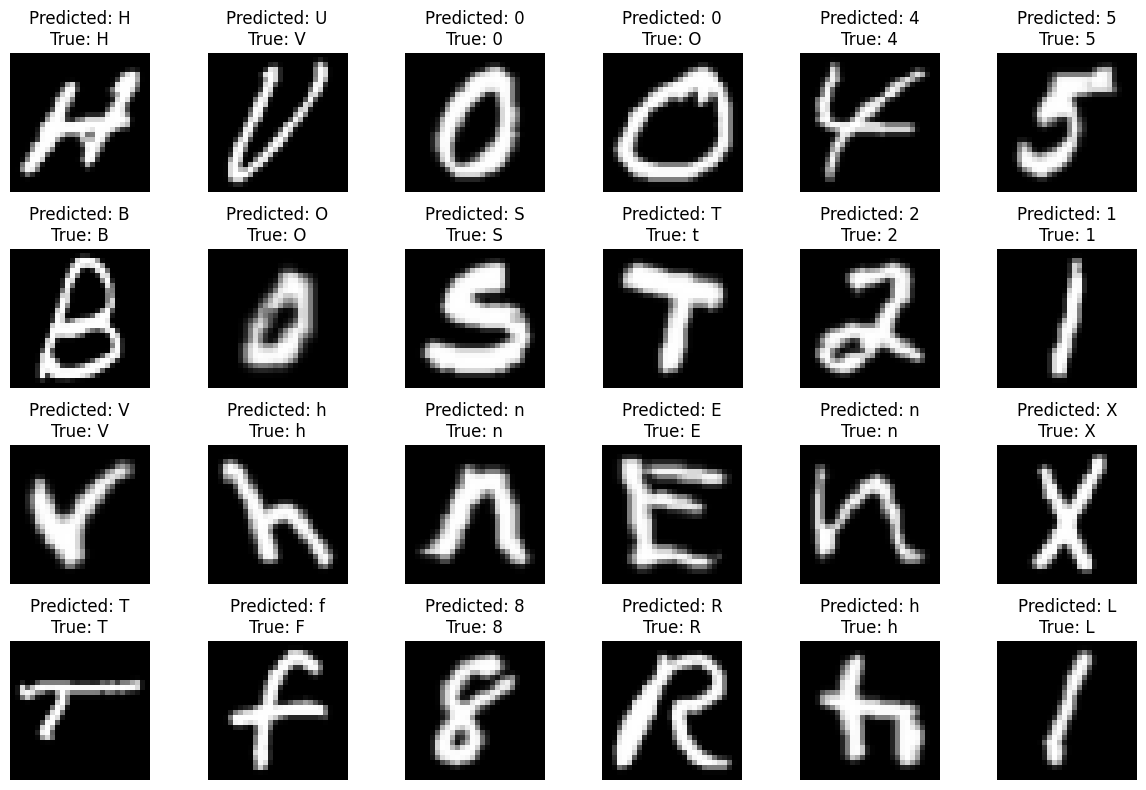

In [27]:
# Visualising some predicted values

#Prediction
y_pred = cnn_model.predict(X_test)

# Set the number of samples to display
num_samples = 24

# Get random indices for the samples
random_indices = random.sample(range(len(X_test)), num_samples)

# Create a figure with subplots
fig = plt.figure(figsize=(12, 8))

for i, idx in enumerate(random_indices):
    # Create a subplot for each sample
    ax = fig.add_subplot(4, 6, i+1)

    # Display the image
    ax.imshow(X_test[idx], cmap=plt.cm.gray)

    # Get the predicted and true labels
    predicted_label = label_dictionary[y_pred[idx].argmax()]
    true_label = label_dictionary[y_test[idx].argmax()]

    # Set the title with prediction and true label
    ax.set_title("Predicted: {}\nTrue: {}".format(predicted_label, true_label))

    # Remove the axis ticks and labels
    ax.axis("off")

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()